In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from catboost import CatBoostClassifier
import catboost
from scipy.special import logsumexp, expit

from src.nf import (
    FCNN,
    ConditionalNormalizingFlowModel,
    UnconditionalNormalizingFlowModel,
    cond_neg_log_likelihood,
    one_hot_encoding,
    ConditionalMAF,
    TorchDistributionWrapper,
    ConditionalNormal,
    TorchDistributionWrapper,
    NormalizingFlowModel,
#     MAF,
    BaseConditionalFlow,
    wrap_cb,
    ConditionalCalibratedModel,
    deduce_calibration_constant,
    FakeCondDistribution,
    BaseConditionalDistribution,
    BaseUnconditionalDistribution,
    CalibratedModel,
    neg_log_likelihood,
    NFLibFlowAdapter,
    ActNorm,
    to_torch,
    to_numpy
)
# from src.nf.classic.utils import Densnet
from src.mrartemev_nflib.flows import NormalizingFlowModel, InvertiblePermutation, Invertible1x1Conv, ActNorm, NSF_AR
from src.mrartemev_nflib.flows import MAF, AffineHalfFlow
from src.mrartemev_nflib.nn import ARMLP, MLP, Densnet
from src.mrartemev_nflib.nn.networks_utils import MaskedLinear

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
! nvidia-smi

Fri Jun  5 19:10:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 25%   59C    P8    11W / 250W |   1296MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 20%   42C    P8     9W / 250W |    161MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [6]:
# 2! wget https://zenodo.org/record/1161203/files/data.tar.gz?download=1

In [7]:
# ! mkdir data
# ! mv 'data.tar.gz?download=1' data/data.tar.gz
# ! ls data

In [8]:
# ! tar -zxvf data/data.tar.gz
# ! ls data

In [9]:
# ! ls data/mnist

In [10]:
class AffineHalfFlow(nn.Module):
    """
    As seen in RealNVP, affine autoregressive flow (z = x * exp(s) + t), where half of the
    dimensions in x are linearly scaled/transfromed as a function of the other half.
    Which half is which is determined by the parity bit.
    - RealNVP both scales and shifts (default)
    - NICE only shifts
    """

    def __init__(self, dim, base_network, scale=True, shift=True, **base_network_kwargs):
        super().__init__()
        self.dim = dim
        self.s_cond = lambda x, context: x.new_zeros(x.size(0), self.dim // 2, device=x.device)
        self.t_cond = lambda x, context: x.new_zeros(x.size(0), self.dim // 2, device=x.device)
        if scale:
            self.s_cond = base_network(self.dim - (self.dim // 2),
                                       self.dim // 2,
                                       **base_network_kwargs)
        if shift:
            self.t_cond = base_network(self.dim - (self.dim // 2),
                                       self.dim // 2,
                                       **base_network_kwargs)

    def forward(self, x, context=None):
        x0, x1 = x[:, ::2], x[:, 1::2]
        s = self.s_cond(x0, context=context)
        t = self.t_cond(x0, context=context)
        z1 = torch.exp(s) * x1 + t  # transform this half as a function of the other
        z = torch.cat([x0, z1], dim=1)
        log_det = torch.sum(s, dim=1)
        return z, log_det

    def inverse(self, z, context=None):
        k = z.shape[1] // 2 + z.shape[1] % 2
        z0, z1 = z[:, :k], z[:, k:]
        s = self.s_cond(z0, context)
        t = self.t_cond(z0, context)
        x1 = (z1 - t) * torch.exp(-s)  # reverse the transform on this half
        x = torch.empty_like(z)
        x[:, ::2] = z0
        x[:, 1::2] = x1
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [11]:
import gzip
import _pickle as pickle

def disp_imdata(xs, imsize, layout=(1,1)):
    """
    Displays an array of images, a page at a time. The user can navigate pages with
    left and right arrows, start over by pressing space, or close the figure by esc.
    :param xs: an numpy array with images as rows
    :param imsize: size of the images
    :param layout: layout of images in a page
    :return: none
    """

    num_plots = np.prod(layout)
    num_xs = xs.shape[0]
    idx = [0]

    # create a figure with suplots
    fig, axs = plt.subplots(layout[0], layout[1])

    if isinstance(axs, np.ndarray):
        axs = axs.flatten()
    else:
        axs = [axs]

    for ax in axs:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    def plot_page():
        """Plots the next page."""

        ii = np.arange(idx[0], idx[0]+num_plots) % num_xs

        for ax, i in zip(axs, ii):
            ax.imshow(xs[i].reshape(imsize), cmap='gray', interpolation='none')
            ax.set_title(str(i))

        fig.canvas.draw()

    def on_key_event(event):
        """Event handler after key press."""

        key = event.key

        if key == 'right':
            # show next page
            idx[0] = (idx[0] + num_plots) % num_xs
            plot_page()

        elif key == 'left':
            # show previous page
            idx[0] = (idx[0] - num_plots) % num_xs
            plot_page()

        elif key == ' ':
            # show first page
            idx[0] = 0
            plot_page()

        elif key == 'escape':
            # close figure
            plt.close(fig)

    fig.canvas.mpl_connect('key_press_event', on_key_event)
    plot_page()

def logit(x):
    """
    Elementwise logit (inverse logistic sigmoid).
    :param x: numpy array
    :return: numpy array
    """
    return np.log(x / (1.0 - x))


class MNIST:
    """
    The MNIST dataset of handwritten digits.
    """

    alpha = 1.0e-6

    class Data:
        """
        Constructs the dataset.
        """

        def __init__(self, data, logit, dequantize, rng):

            x = self._dequantize(data[0], rng) if dequantize else data[0]  # dequantize pixels
            self.x = self._logit_transform(x) if logit else x              # logit
            self.labels = data[1]                                          # numeric labels
            self.y = one_hot_encoding(self.labels, 10)                     # 1-hot encoded labels
            self.N = self.x.shape[0]                                       # number of datapoints

        @staticmethod
        def _dequantize(x, rng):
            """
            Adds noise to pixels to dequantize them.
            """
            return x + rng.rand(*x.shape) / 256.0

        @staticmethod
        def _logit_transform(x):
            """
            Transforms pixel values with logit to be unconstrained.
            """
            return logit(MNIST.alpha + (1 - 2*MNIST.alpha) * x)

    def __init__(self, logit=False, dequantize=True):

        # load dataset
        f = gzip.open('data/mnist/mnist.pkl.gz', 'rb')
#         f = open('data/mnist.pkl', 'rb')
        trn, val, tst = pickle.load(f, encoding='latin1') 
        f.close()

        rng = np.random.RandomState(42)
        self.trn = self.Data(trn, logit, dequantize, rng)
        self.val = self.Data(val, logit, dequantize, rng)
        self.tst = self.Data(tst, logit, dequantize, rng)

        self.n_dims = self.trn.x.shape[1]
        self.n_labels = self.trn.y.shape[1]
        self.image_size = [int(np.sqrt(self.n_dims))] * 2

    def show_pixel_histograms(self, split, pixel=None):
        """
        Shows the histogram of pixel values, or of a specific pixel if given.
        """

        data_split = getattr(self, split, None)
        if data_split is None:
            raise ValueError('Invalid data split')

        if pixel is None:
            data = data_split.x.flatten()

        else:
            row, col = pixel
            idx = row * self.image_size[0] + col
            data = data_split.x[:, idx]

        n_bins = int(np.sqrt(data_split.N))
        fig, ax = plt.subplots(1, 1)
        ax.hist(data, n_bins, normed=True)
        plt.show()

    def show_images(self, split):
        """
        Displays the images in a given split.
        :param split: string
        """

        # get split
        data_split = getattr(self, split, None)
        if data_split is None:
            raise ValueError('Invalid data split')

        # display images
        disp_imdata(data_split.x, self.image_size, [6, 10])

        plt.show()

In [12]:
# https://github.com/gpapamak/maf/blob/ea057bf6dd2e53dd8a0bc162880db72cf99e063d/experiments.py#L51
mnist = MNIST(logit=True, dequantize=False)

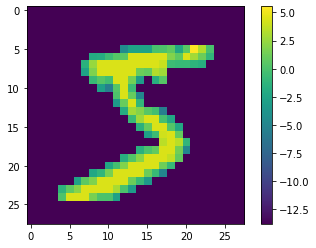

In [13]:
X, Y = mnist.trn.x, mnist.trn.y
dim, cond_dim = X.shape[1], Y.shape[1]
X = X.astype(np.float32)
X_train, X_test, Y_train, Y_test = mnist.trn.x.astype(np.float32), mnist.tst.x.astype(np.float32), mnist.trn.y.astype(np.float32), mnist.tst.y.astype(np.float32)

plt.imshow(mnist.trn.x[0].reshape(28, 28))
plt.colorbar()

In [14]:
X_train_tensor = torch.from_numpy(X_train).to(device)
X_test_tensor = torch.from_numpy(X_test).to(device)
Y_train_tensor = torch.from_numpy(Y_train).to(device)
Y_test_tensor = torch.from_numpy(Y_test).to(device)

In [15]:
def data_gen(X, Y, batch_size, noize=True):
    noize_dist = torch.distributions.MultivariateNormal(
        torch.zeros(X.shape[1]).to(device),
        torch.eye(X.shape[1]).to(device)
    )
    while True:
        perm = torch.randperm(len(X))
        X_, Y_ = X[perm], Y[perm]
        if noize:
            X_ += noize_dist.sample_n(X_.shape[0])
        for i in range(0, len(X), batch_size):
            yield X_[i: i + batch_size], Y_[i: i + batch_size]

In [16]:
flows = []
for i in range(6):
    flows.append(NFLibFlowAdapter(ActNorm(dim=dim)))
    flows.append(NFLibFlowAdapter(Invertible1x1Conv(dim=dim)))
    flows.append(NFLibFlowAdapter(AffineHalfFlow(dim=dim, hidden_features=[256, 256, 256, 256, 256], base_network=Densnet, context=cond_dim)))
    flows.append(NFLibFlowAdapter(InvertiblePermutation(dim).to(device)))

prior = ConditionalNormal(
    torch.zeros(dim).to(device), torch.eye(dim).to(device),
    nn.Linear(cond_dim, dim), nn.Linear(cond_dim, dim)
).to(device)
model = ConditionalNormalizingFlowModel(dim, cond_dim, prior, flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [17]:
def init(l):
    if isinstance(l, nn.Linear):
        nn.init.normal_(l.weight, 0, 1e-5)
        nn.init.normal_(l.bias, 0, 1e-5)
model.apply(init)

NFModel(dim=784, prior=ConditionalNormal, flows=['NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter', 'NFLibFlowAdapter'])

In [18]:
# model.eval()
# with torch.no_grad():
#     cond = torch.eye(10).to(device)
#     model.forward(prior.sample_n(10, cond), cond)
#     samples = model.sample_n(1, Y_train_tensor[:1]).detach().cpu().numpy()

# plt.imshow(samples[0].reshape(28, 28))

In [19]:
# plt.hist(samples[0], bins=50);

In [20]:
epoches = 10001
metrics_ll_train, metrics_ll_test = [], []
best_loss = -10000

-1083.2137451171875 -1125.2923583984375


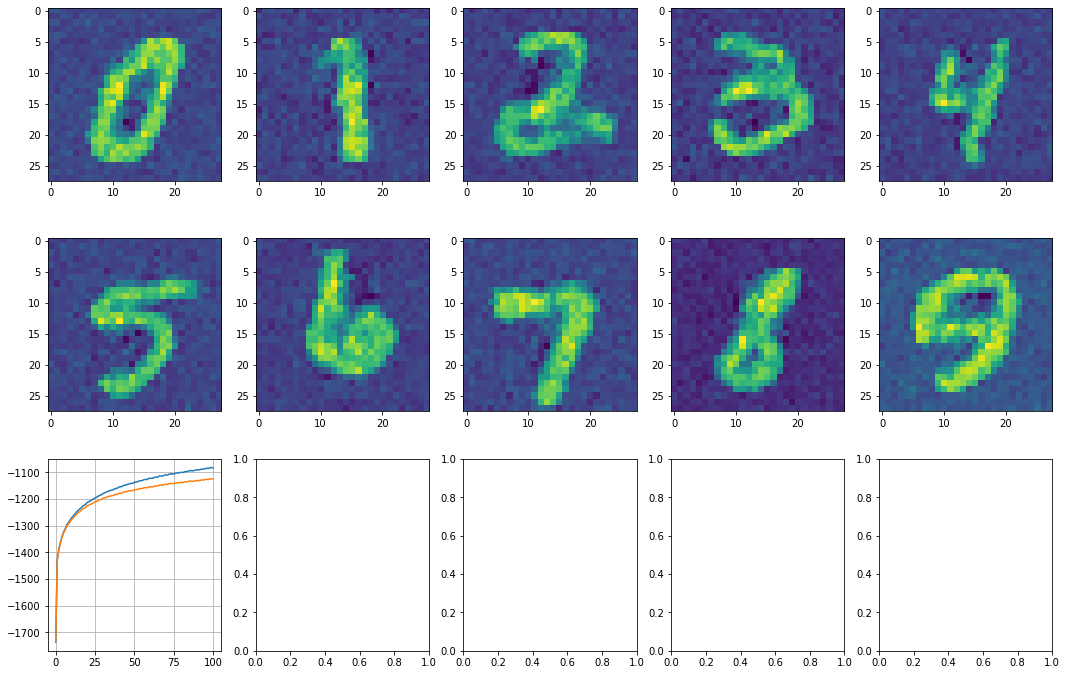

In [21]:
train_gen = data_gen(X_train_tensor, Y_train_tensor, 4096)
test_gen = data_gen(X_test_tensor, Y_test_tensor, 4096)

for i in range(len(metrics_ll_train) * 100, epoches):
    model.train()
    optimizer.zero_grad()
    logp_x = model.log_prob(*next(train_gen))
    loss = -torch.mean(logp_x)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    if i % 100 == 0:
        model.eval()
        with torch.no_grad():
            log_prob = model.log_prob(X_train_tensor[:10000], Y_train_tensor[:10000])
            metrics_ll_train.append(torch.mean(log_prob).item())
            log_prob = model.log_prob(X_test_tensor[:10000], Y_test_tensor[:10000])
            metrics_ll_test.append(torch.mean(log_prob).item())
            
            n_samples = 10
            cond = torch.eye(10).to(device)
            samples = model.sample_n(10, cond).detach().cpu().numpy()
            
            if metrics_ll_test[-1] > best_loss:
                torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'metrics_ll_train': metrics_ll_train,
                    'metrics_ll_test': metrics_ll_test,
                }, './mnist_best_3')

        clear_output(False)
        print(metrics_ll_train[-1], metrics_ll_test[-1])
        fig, axs = plt.subplots(3, 5, figsize=(18, 12))
        
        for i in range(10):
            axs[i // 5, i % 5].imshow(samples[i].reshape(28, 28))
        
        axs[2, 0].plot(metrics_ll_train, label='ll train')
        axs[2, 0].plot(metrics_ll_test, label='ll test')
        axs[2, 0].grid()
        plt.show()

In [89]:
torch.save({
    'epoch': i,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'metrics_ll_train': metrics_ll_train,
    'metrics_ll_test': metrics_ll_test,
}, './mnist_glow_100k_asdf')

In [19]:
model.load_state_dict(torch.load('./mnist_glow_100k_asdf')['model_state_dict'])

<All keys matched successfully>

In [20]:
# checkpoint = torch.load('./mnist_best_2')
# model.load_state_dict(checkpoint['model_state_dict'])

# print(
#     checkpoint['epoch'],
#     checkpoint['metrics_ll_test'][-1],
#     checkpoint['metrics_ll_train'][-1]
# )

In [22]:
model.eval()
with torch.no_grad():
    cond = torch.eye(10).to(device)
    cond = torch.cat([cond] * 10, dim=0)
    samples = model.sample_n(100, cond).detach().cpu().numpy()

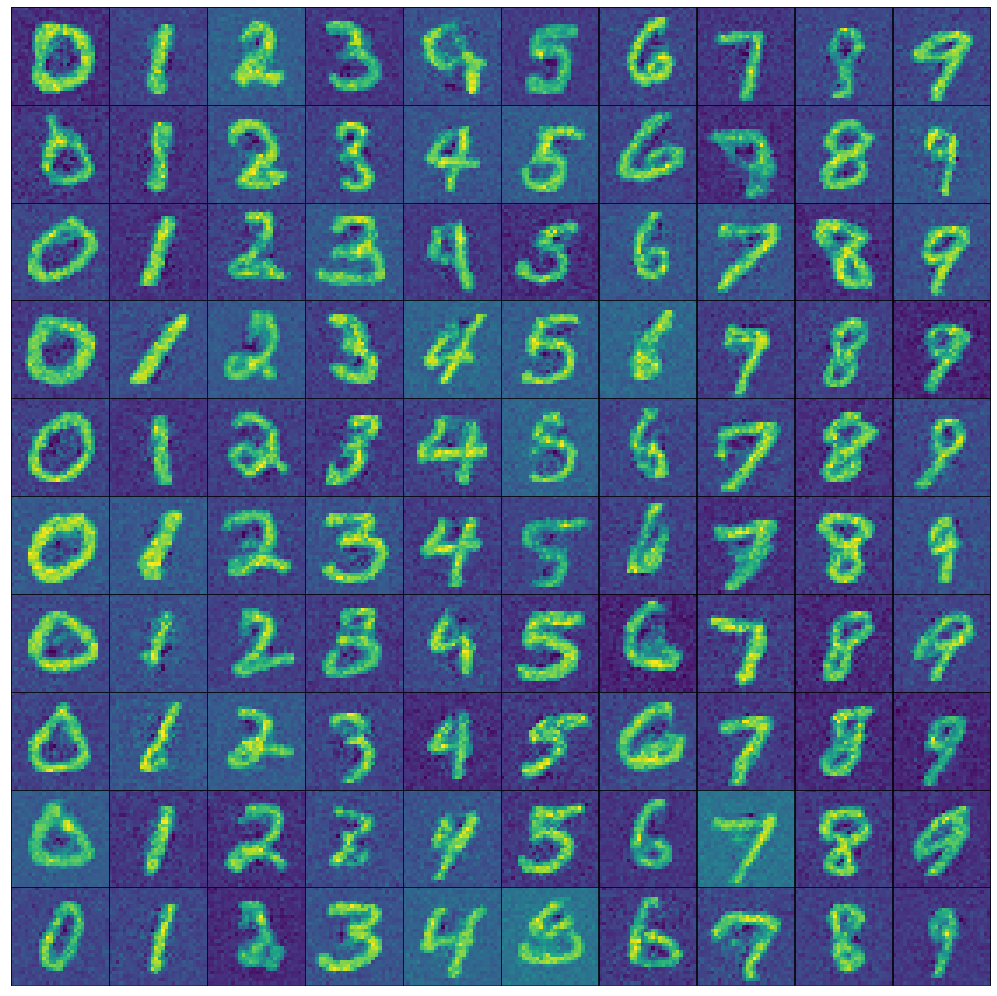

In [23]:
fig, axs = plt.subplots(10, 10, figsize=(18, 18))
# model.eval()
# with torch.no_grad():
#     cond = torch.eye(10).to(device)
#     cond = torch.cat([cond] * 10, dim=0)
#     samples = model.sample_n(100, cond).detach().cpu().numpy()

for i in range(100):
    axs[i // 10, i % 10].imshow(samples[i].reshape(28, 28))
    axs[i // 10, i % 10].set_xticks([], [])
    axs[i // 10, i % 10].set_yticks([], [])

plt.subplots_adjust(wspace=-0.2, hspace=0)

In [24]:
model.eval()
with torch.no_grad():
    samples = model.sample_n(len(X_train), Y_train_tensor).detach().cpu().numpy()
samples.shape

(50000, 784)

In [25]:
X_clf = np.vstack([
    np.hstack([samples, Y_train]),
    np.hstack([X_train, Y_train])
])
Y_clf = np.hstack([np.zeros(len(samples)), np.ones(len(X_train))]).astype(np.float32)
perm = torch.randperm(len(X_clf))
X_clf, Y_clf = X_clf[perm], Y_clf[perm]

n = X_clf.shape[0]
X_clf_train, X_clf_test, Y_clf_train, Y_clf_test = X_clf[: n * 7 // 10], X_clf[n * 7 // 10: ], Y_clf[: n * 7 // 10], Y_clf[n * 7 // 10: ]

In [26]:
X_clf_train_tensor = torch.from_numpy(X_clf_train).to(device)
X_clf_test_tensor = torch.from_numpy(X_clf_test).to(device)
Y_clf_train_tensor = torch.from_numpy(Y_clf_train).to(device)
Y_clf_test_tensor = torch.from_numpy(Y_clf_test).to(device)

In [94]:
class MNISTClf(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(3, 5, 5)
        self.conv4 = nn.Conv2d(5, 5, 5)
        self.fc1 = nn.Linear(5 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x[:, :28 * 28].view(-1, 1, 28, 28)))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 5 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1)

In [95]:
# class MNISTClf(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 3, 7)
#         self.conv2 = nn.Conv2d(3, 3, 7)
#         self.pool = nn.MaxPool2d(2, 2)
# #         self.conv3 = nn.Conv2d(3, 5, 5)
# #         self.conv4 = nn.Conv2d(5, 5, 5)
#         self.fc1 = nn.Linear(3 * 8 * 8, 32)
# #         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 1)

#     def forward(self, x):
#         x = F.relu(self.conv1(x[:, :28 * 28].view(-1, 1, 28, 28)))
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
# #         print(x.shape)
# #         x = F.relu(self.conv3(x))
# #         x = F.relu(self.conv4(x))
#         x = x.view(-1, 3 * 8 * 8)
#         x = F.relu(self.fc1(x))
# #         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x.view(-1)

In [96]:
clf = MNISTClf().to(device)
# clf = Densnet(794, 1, [256, 256, 256, 256, 256, 256]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(clf.parameters(), lr=0.005)#, weight_decay=0.0001)

In [97]:
# def init(l):
#     if isinstance(l, nn.Linear):
#         nn.init.normal_(l.weight, 0, 1e-5)
#         nn.init.normal_(l.bias, 0, 1e-5)
# clf.apply(init)

In [98]:
epoches = 501
loss_train, loss_test = [], []

In [99]:
X_clf_train_tensor.shape

torch.Size([70000, 794])

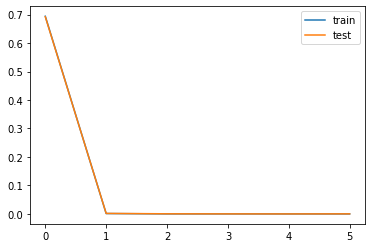

In [100]:
train_gen = data_gen(X_clf_train_tensor, Y_clf_train_tensor, 10000, noize=False)
test_gen = data_gen(X_clf_test_tensor, Y_clf_test_tensor, 10000, noize=False)

for i, (X_batch, Y_batch) in zip(range(len(loss_train), epoches), train_gen):
    clf.train()
    optimizer.zero_grad()
    logits = clf(X_batch)
    loss = criterion(logits.view(-1), Y_batch)
    loss.backward()
    nn.utils.clip_grad_norm_(clf.parameters(), 10)
    optimizer.step()
    
    if i % 100 == 0:
        loss_train.append(loss.item())
        clf.eval()
        with torch.no_grad():
            X_batch, Y_batch = next(test_gen)
            loss_test.append(criterion(clf(X_batch).view(-1), Y_batch).item())
        
        clear_output(False)
        plt.plot(loss_train, label='train')
        plt.plot(loss_test, label='test')
        plt.legend()
        plt.show()

In [101]:
clf.eval()
with torch.no_grad():
    X_batch, Y_batch = next(test_gen)
    preds = clf(X_batch).detach().cpu().numpy()
    print(roc_auc_score(Y_batch.detach().cpu().numpy(), preds))

1.0


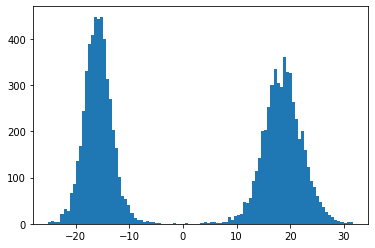

In [102]:
plt.hist(preds, bins=100);

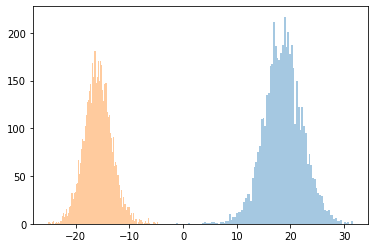

In [103]:
plt.hist(preds[Y_batch.detach().cpu().numpy() == 1], bins=100, alpha=0.4);
plt.hist(preds[Y_batch.detach().cpu().numpy() == 0], bins=100, alpha=0.4);

In [104]:
model.eval()
with torch.no_grad():
    print(model.log_prob(X_test_tensor[:10000], Y_test_tensor[:10000]).mean().item())

-1125.2923583984375


-13.956949138082479


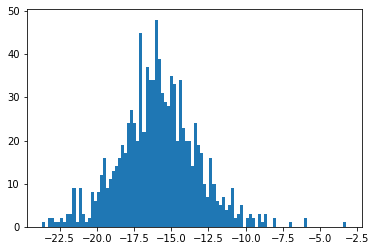

In [106]:
model.eval()
clf.eval()
with torch.no_grad():
    n_samples = 1000
    samples = model.sample_n(n_samples, Y_test_tensor[:n_samples])
    logits = clf(samples.view(-1, 1, 28, 28)).detach().cpu().numpy()
    calib_constant = logsumexp(np.clip(logits, -100, -12)) - np.log(n_samples)
plt.hist(logits, bins=100);
print(calib_constant)

In [107]:
model.eval()
clf.eval()
with torch.no_grad():
    logits = clf(X_test_tensor[:10000].view(-1, 1, 28, 28))
    print(
        (model.log_prob(X_test_tensor[:10000], Y_test_tensor[:10000]) + logits).mean().item() - calib_constant
    )

-1092.873983479105


In [108]:
clf_wrap = lambda x: np.clip(clf(to_torch(x).to(device)).detach().cpu().numpy(), -100, -12)

In [173]:
def conditional_rejection_sampling(
        clf,
        maj_dist,
        c,
        condition
):
    need_sample = np.ones(len(condition), dtype=np.bool)
    samples = np.empty((len(condition), maj_dist.dim, ))
    np_cond = condition.detach().cpu().numpy()
    redjected = []
    while True:
        idxs = np.where(need_sample)[0]
        print(idxs % 10)
        if len(idxs) == 0:
            break
#         print(condition.shape)
        samples_ = maj_dist.sample_n(len(idxs), condition[idxs]).detach().cpu().numpy()
        accept_log_prob = clf(np.hstack([samples_, np_cond[idxs]])) - np.log(c)
#         accept_log_prob = clf(samples_) - np.log(c)
#         print(accept_log_prob)
        is_accept = (accept_log_prob > np.log(np.random.uniform(0, 1, len(idxs))))
        need_sample[idxs[is_accept]] = False
        samples[idxs[is_accept]] = samples_[is_accept]
#         print(np_cond)
#         print(condition[idxs[~is_accept]].shape)
        redjected.append([samples_[~is_accept], condition[idxs[~is_accept]], accept_log_prob[~is_accept]])
    return samples, redjected

In [174]:
clf.eval()
model.eval()
with torch.no_grad():
    imgs, redj = conditional_rejection_sampling(clf_wrap, model, np.exp(-12), torch.cat([torch.eye(10).to(device)] * 10, dim=0))

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 5 6 8 9 0 1 2 3 5 6 7 8 9 0 1 2 3 5 6 8 9 0 1 2 3 5 6 7 8 9 4 6 7
 8 9 0 1 2 3 4 5 6 7 8 9 1 2 4 5 6 7 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 5 6 7 8
 0 1 3 6 7 8 9]
[0 1 2 3 5 6 8 9 1 2 3 5 6 7 8 9 0 1 2 3 6 8 0 1 2 3 5 6 7 8 9 4 7 8 9 1 2
 5 6 7 8 9 1 2 4 5 7 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 5 6 7 8 0 1 3 6 7 8 9]


/home/robdrynkin/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


[0 1 2 3 5 6 8 9 1 2 3 5 6 7 8 0 1 2 6 8 0 1 2 3 5 6 7 8 4 7 9 1 2 5 6 7 8
 9 1 2 4 5 7 9 0 1 2 3 4 5 6 7 8 9 1 3 5 6 7 8 0 1 3 6 7 9]
[0 1 3 5 6 9 1 2 3 5 6 7 8 0 1 2 6 8 1 3 5 6 7 8 7 9 1 2 5 6 7 8 1 2 5 7 9
 0 1 2 3 5 6 7 8 9 1 3 5 6 7 8 0 1 6 7 9]
[0 1 3 5 6 9 1 2 3 5 7 8 0 1 2 6 8 1 3 5 6 7 7 9 1 2 5 7 8 2 7 9 0 1 2 3 5
 6 7 8 9 1 3 5 7 8 1 6 7 9]
[0 1 3 5 9 1 2 3 5 7 8 1 2 6 1 3 5 6 7 7 9 2 5 7 8 2 7 9 0 1 2 3 5 6 7 8 1
 3 5 7 8 1 6 9]
[1 3 5 9 1 2 3 5 8 2 6 1 3 6 7 7 9 2 5 7 8 2 7 9 1 2 3 5 6 7 8 1 3 5 7 1 6
 9]
[1 3 5 1 2 3 5 8 2 6 1 3 6 7 7 9 5 7 8 2 7 9 1 2 3 5 6 7 1 3 5 7 1 6 9]
[1 3 5 1 2 3 5 8 2 1 3 6 7 9 5 7 8 2 7 9 1 2 3 5 6 7 1 3 5 7 6]
[3 5 1 2 3 5 8 2 1 3 6 7 9 5 7 8 2 7 9 1 2 3 5 6 7 1 5 7 6]
[3 5 1 2 3 5 1 6 7 9 5 7 2 7 9 1 2 3 5 7 1 7]
[5 1 2 3 5 1 6 7 5 7 2 7 9 1 2 3 5 7 1]
[5 1 2 3 5 1 6 7 5 7 2 7 9 1 2 3 5 7 1]
[5 1 2 3 5 6 7 7 2 7 9 1 2 3 5 7 1]
[5 1 2 3 5 6 7 7 9 3 5 7 1]
[5 1 2 3 5 6 7 9 3 5 7]
[5 1 2 3 5 6 7 9 5 7]
[5 1 2 3 5 6 7 9 5 7]
[5 1 2 3 5 6 7 9 5 7]

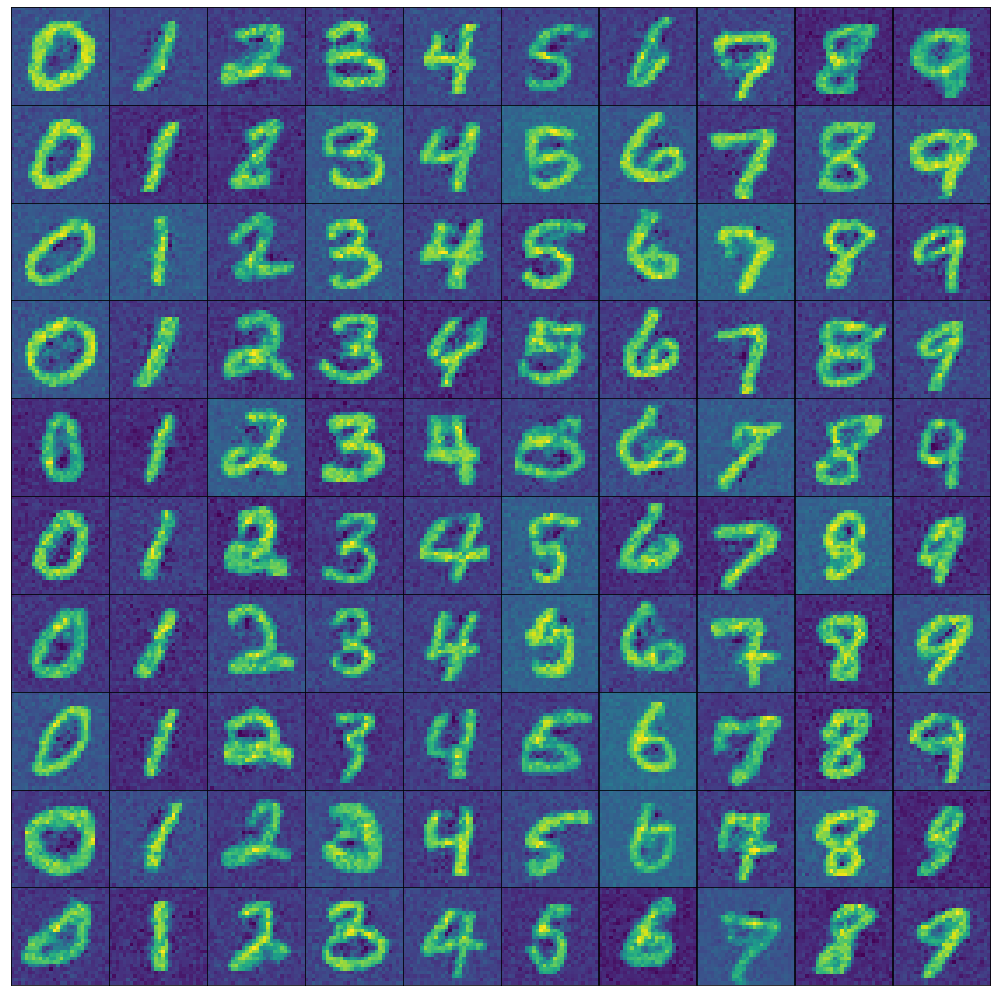

In [175]:
fig, axs = plt.subplots(10, 10, figsize=(18, 18))

for i in range(100):
    axs[i // 10, i % 10].imshow(imgs[i].reshape(28, 28))
    axs[i // 10, i % 10].set_xticks([], [])
    axs[i // 10, i % 10].set_yticks([], [])

plt.subplots_adjust(wspace=-0.2, hspace=0)

In [190]:
a = [x[1].detach().cpu().numpy() for x in redj]
b = [x[2] for x in redj]
c = [x[0] for x in redj]
a = np.argmax(np.vstack(a), axis=1)
b = np.hstack(b)
c = np.vstack(c)

In [183]:
order = np.argsort(b)

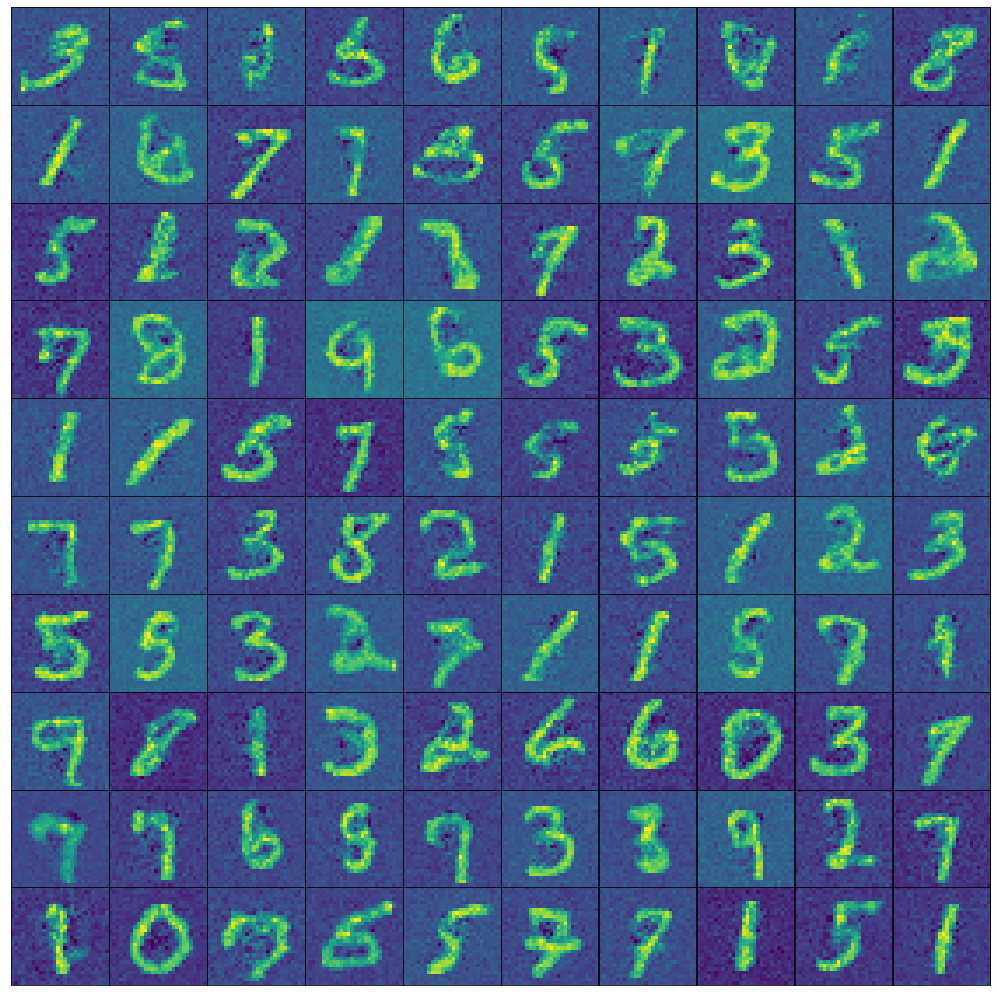

In [184]:
fig, axs = plt.subplots(10, 10, figsize=(18, 18))

for i in range(100):
    axs[i // 10, i % 10].imshow(c[order][i].reshape(28, 28))
    axs[i // 10, i % 10].set_xticks([], [])
    axs[i // 10, i % 10].set_yticks([], [])

plt.subplots_adjust(wspace=-0.2, hspace=0)